# Imports

In [67]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


# Reproducibilitty

In [68]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Utils

In [69]:
def plot_loss_curve(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Erro de Treino')
    plt.plot(history.history['val_loss'], label='Erro de Validação')
    plt.title('Curva de Erro (Loss) do Autoencoder')
    plt.xlabel('Época')
    plt.ylabel('Erro Médio Quadrático (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_reconstructions(model, data, n=10):
    reconstructed_imgs = model.predict(data)
    
    if data.shape[1] == 784:
        data = data.reshape(-1, 28, 28)
        reconstructed_imgs = reconstructed_imgs.reshape(-1, 28, 28)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Imagens Originais')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Imagens Reconstruídas')
    plt.show()

# Data Preparation

In [70]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train, x_val = train_test_split(
    x_train, test_size=0.2, random_state=42
)

x_train_conv = np.expand_dims(x_train.astype('float32') / 255., axis=-1)
x_test_conv = np.expand_dims(x_test.astype('float32') / 255., axis=-1)
x_val_conv = np.expand_dims(x_val.astype('float32') / 255., axis=-1)

In [71]:
print(f"Formato dos dados de treino para CNN: {x_train_conv.shape}")
print(f"Formato dos dados de validação para CNN: {x_val_conv.shape}")
print(f"Formato dos dados de teste para CNN: {x_test_conv.shape}")

Formato dos dados de treino para CNN: (48000, 28, 28, 1)
Formato dos dados de validação para CNN: (12000, 28, 28, 1)
Formato dos dados de teste para CNN: (10000, 28, 28, 1)


In [72]:
x_train_flat = (x_train.astype('float32') / 255.).reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = (x_test.astype('float32') / 255.).reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val_flat = (x_val.astype('float32') / 255.).reshape((len(x_val), np.prod(x_val.shape[1:])))

In [73]:
print(f"Formato dos dados de treino para DNN: {x_train_flat.shape}")
print(f"Formato dos dados de validação para DNN: {x_val_flat.shape}")
print(f"Formato dos dados de teste para DNN: {x_test_flat.shape}")

Formato dos dados de treino para DNN: (48000, 784)
Formato dos dados de validação para DNN: (12000, 784)
Formato dos dados de teste para DNN: (10000, 784)


# Autoenconder Fully Conected

## Model

In [74]:
input_dim = x_train_flat.shape[1]  # 28*28 = 784
latent_dim = 16

input_layer = Input(shape=(input_dim,), name='encoder_input')

# Codificador (Encoder)
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu', name='latent_space')(encoder)

# Decodificador (Decoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid', name='decoder_output')(decoder)

autoencoder_dense = Model(inputs=input_layer, outputs=decoder, name='autoencoder_dense')
autoencoder_dense.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_dense.summary()

Model: "autoencoder_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,888 (866.75 KB)

 Trainable params: 221,888 (866.75 KB)

 Non-trainable params: 0 (0.00 B)

## Train

In [75]:
history_dense = autoencoder_dense.fit(
    x_train_flat, 
    x_train_flat, 
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(x_val_flat, x_val_flat)
)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4124 - val_loss: 0.3437
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3246 - val_loss: 0.3139
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3104 - val_loss: 0.3078
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3058 - val_loss: 0.3041
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3024 - val_loss: 0.3010
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2994 - val_loss: 0.2987
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2971 - val_loss: 0.2966
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2954 - val_loss: 0.2951
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2940 - val_loss: 0.2944
Epoch 10/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2929 - val_loss: 0.2935
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2919 - val_loss: 0.2917
Epoch 12/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

## Results


Resultados para o Autoencoder Convolucional:


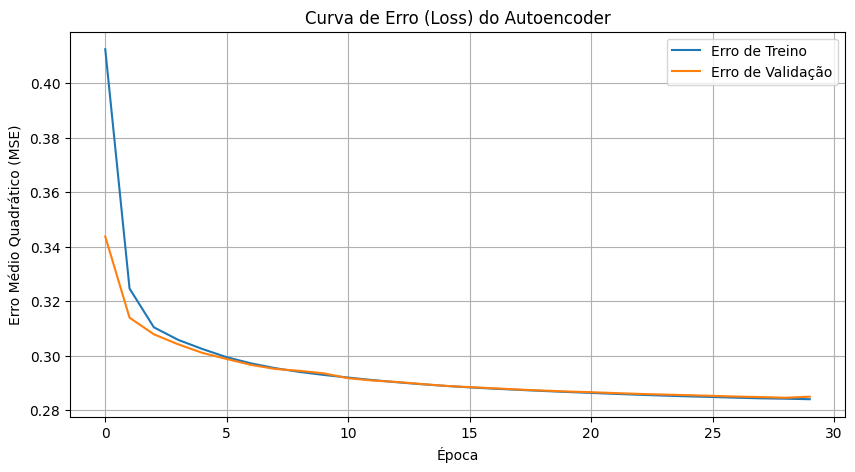

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


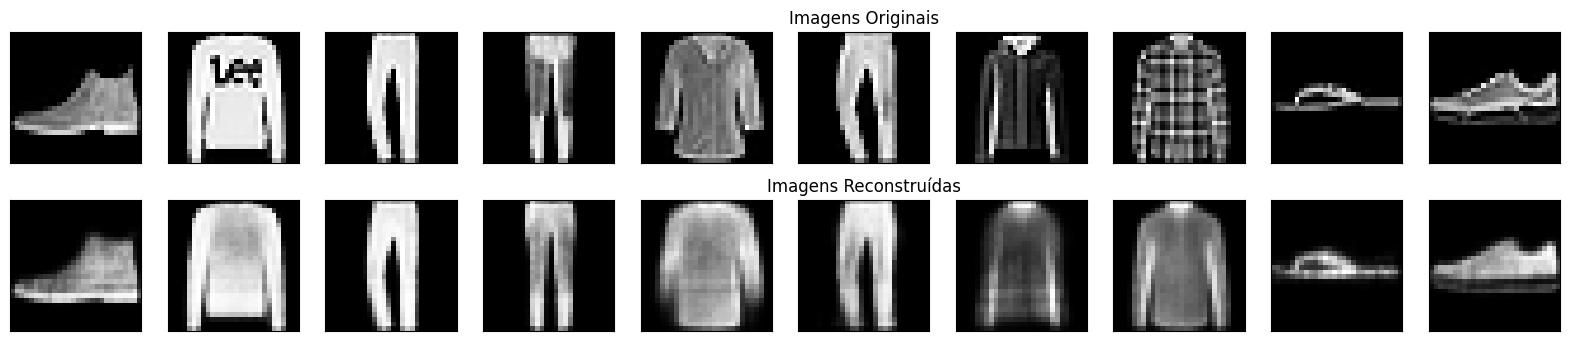

In [76]:
print("\nResultados para o Autoencoder Convolucional:")
plot_loss_curve(history_dense)
plot_reconstructions(autoencoder_dense, x_test_flat, n=10)

# Autoencoder Convolucional

## Model

In [77]:
input_layer = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x) # 14x14x16
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 7x7x8 (espaço latente)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 14x14x8
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 28x28x16
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # 28x28x1

autoencoder_conv = Model(input_layer, decoded)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy') 

autoencoder_conv.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

## Train

In [78]:
history_conv = autoencoder_conv.fit(
    x_train_conv,
    x_train_conv,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val_conv, x_val_conv)
)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3347 - val_loss: 0.2849
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2810 - val_loss: 0.2784
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2764 - val_loss: 0.2750
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2736 - val_loss: 0.2727
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2717 - val_loss: 0.2711
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2703 - val_loss: 0.2699
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2693 - val_loss: 0.2690
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2684 - val_loss: 0.2682
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2677 - val_loss: 0.2676
Epoch 10/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2670 - val_loss: 0.2669
Epoch 11/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2664 - val_loss: 0.2664
Epoch 12/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 

## Results


Resultados para o Autoencoder Convolucional:


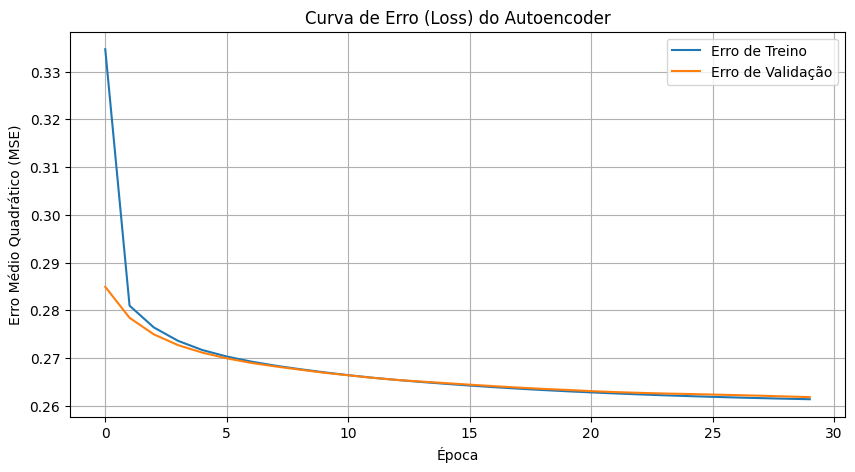

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


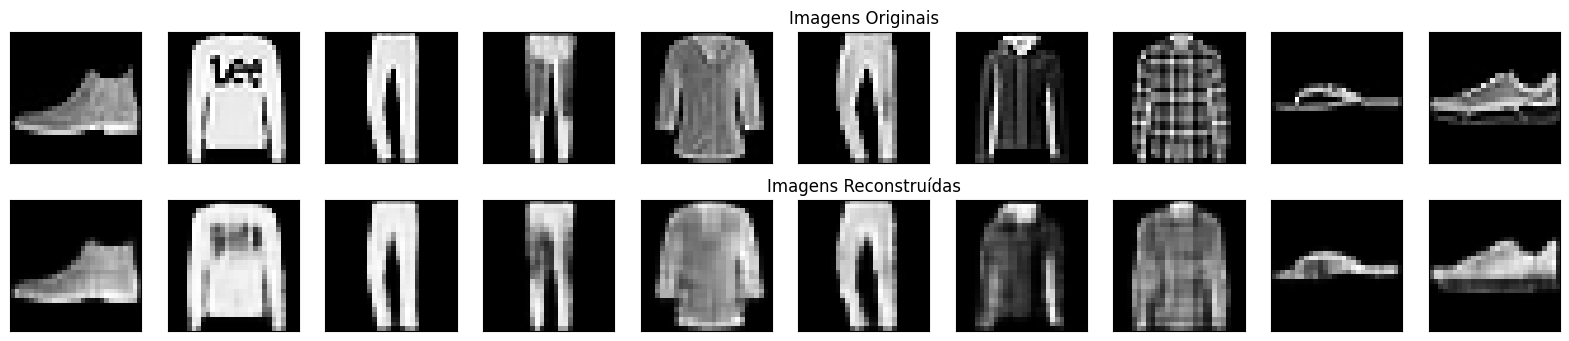

In [79]:
print("\nResultados para o Autoencoder Convolucional:")
plot_loss_curve(history_conv)
plot_reconstructions(autoencoder_conv, x_test_conv, n=10)